In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
import re
from collections import OrderedDict

# Function for data import, processing and plotting

In [2]:
KEYS = ('year', 'month', 'day', 'hour', 'minute', 'second', 'ms', 'iter', 'MB')
TYPES = (int, int, int, int, int, int, int, int, float)
LINE_RE = r'^(\d+)-(\d+)-(\d+)\s(\d+):(\d+):(\d+),(\d+).*\#\[(\d+)].*MB:([0-9]*[.][0-9]+)'
re_complied = re.compile(LINE_RE)

def parse_line(line):
    try:
        values = re_complied.match(line).groups()
        info = OrderedDict(zip(KEYS, values))
        return info
    except Exception as err:
        print err
        return None

def process_data_frame(df):
    dt_list = []
    for idx, row in df.iterrows():
        args = map(int, list(row[0:6]))
        dt = datetime.datetime(*args)
        dt_list.append(dt)
    df['datetime'] = dt_list
    df['unix_time'] = map(lambda x: int(time.mktime(x.timetuple())), dt_list)
    return df

def truncate_time_range(df, minutes=90):
    start_date = df['datetime'].min()
    end_date = start_date + datetime.timedelta(minutes=minutes)
    mask = (df['datetime'] > start_date) & (df['datetime'] <= end_date)
    df = df.loc[mask]
    return df

def data_frame_from_log(log_path):
    with open(log_path, 'rb') as f:
        txt_lines = f.readlines()
    data_list = []
    for line in txt_lines:
        line_info = parse_line(line)
        if line_info is not None:
            data_list.append(line_info)
    df = pd.DataFrame(data_list)
    df = process_data_frame(df)
    df = truncate_time_range(df, minutes=60)
    return df

def extract_leak_rate(df, title):
    x = np.array(df['unix_time'].values, dtype=np.int)
    x -=x.min()
    y = np.array(df['MB'].values, dtype=np.float)
    fit = np.polyfit(x, y, 1)
    m, c = fit #  m [MB/s]
    fit_fn = np.poly1d(fit) 
    # fit_fn is now a function which takes in x and returns an estimate for y
    plt.plot(x, y, 'o', x, fit_fn(x), '--k')
    plt.xlabel('Seconds')
    plt.ylabel('MB leaked')
    info_txt = 'Leak Rate: {0:.2f} MB/hr'.format(m*60*60)  # MB/hour
    plt.title('{}. {}'.format(title, info_txt))
    plt.show()
    return m*60*60

def extract_leak_rate_multiple(df_list, labels):
    for df, label in zip(df_list, labels):
        x = np.array(df['unix_time'].values, dtype=np.int)
        x -= x.min()
        y = np.array(df['MB'].values, dtype=np.float)
        y -= y.min()
        fit = np.polyfit(x, y, 1)
        m, c = fit #  m [MB/s]
        fit_fn = np.poly1d(fit) 
        # fit_fn is now a function which takes in x and returns an estimate for y
        info_txt = '{0:.2f} MB/hr'.format(m*60*60)  # MB/hour
        plt.plot(x, y, 'o', alpha=0.5, label='{}: {}'.format(label, info_txt))
        plt.plot(x, fit_fn(x), '--k')
    plt.xlabel('Seconds')
    plt.ylabel('Growth (MB)')
    plt.title('Leak Rate')
    plt.legend()
    plt.show()


# Run analysis

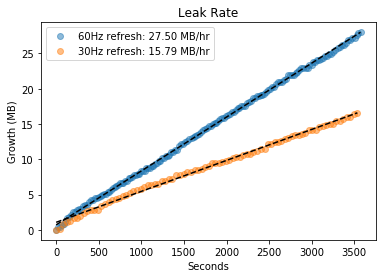

In [3]:
# Data files are read, processed and plotted
df_60 = data_frame_from_log('chaco_60Hz.log')
df_30 = data_frame_from_log('chaco_30Hz.log')
extract_leak_rate_multiple([df_60, df_30], ['60Hz refresh', '30Hz refresh'])